In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import csv
import random 

In [17]:
batch_size = 50

In [18]:
#to make visualizing the boards a bit easier, we will create a function that outputs the Tic Tac Toe boards with Xs and Os
def print_board(board):
    symbols = ['O',' ','X']
    board_plus1 = [int(x) + 1 for x in board]
    print(' ' + symbols[board_plus1[0]] + ' | ' + symbols[board_plus1[1]] + ' | ' + symbols[board_plus1[2]])
    print('----------')
    print(' ' + symbols[board_plus1[3]] + ' | ' + symbols[board_plus1[4]] + ' | ' + symbols[board_plus1[5]])
    print('----------')
    print(' ' + symbols[board_plus1[6]] + ' | ' + symbols[board_plus1[7]] + ' | ' + symbols[board_plus1[8]])    

In [19]:
#Now we have to create a function that will return a new board and optimal response position under a transformation
def get_symmetry(board, response, transformation):
    '''
    :param board: list of integers 9 long:
     opposing mark = -1
     friendly mark = 1
     empty space = 0
    :param transformation: one of five transformations on a board:
     'rotate180', 'rotate90', 'rotate270', 'flip_v', 'flip_h'
    :return: tuple: (new_board, new_response)
    '''
    if transformation == 'rotate180':
        new_response = 8 - response
        return(board[::-1], new_response)
    elif transformation == 'rotate90':
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return([value for item in tuple_board for value in item], new_response)
    elif transformation == 'rotate270':
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return([value for item in tuple_board for value in item], new_response)
    elif transformation == 'flip_v':
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(response)
        return(board[6:9] +  board[3:6] + board[0:3], new_response)
    elif transformation == 'flip_h':  # flip_h = rotate180, then flip_v
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(response)
        new_board = board[::-1]
        return(new_board[6:9] +  new_board[3:6] + new_board[0:3], new_response)
    else:
        raise ValueError('Method not implmented.')

In [20]:
#Create a function that will load the file with the f boards and reponses and store it as a list of tuples.
def get_moves_from_csv(csv_file):
    '''
    :param csv_file: csv file location containing the boards w/ responses
    :return: moves: list of moves with index of best response
    '''
    moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            moves.append(([int(x) for x in row[0:9]],int(row[9])))
    return(moves)

In [21]:
#Now we will tie everything together to create a funcion that will return a randomly transformed board and response:
def get_rand_move(moves, rand_transforms=2):
    '''
    :param moves: list of the boards w/responses
    :param rand_transforms: how many random transforms performed on each
    :return: (board, response), board is a list of 9 integers, response is 1 int
    '''
    (board, response) = random.choice(moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for i in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, response) = get_symmetry(board, response, random_transform)
    return(board, response)

In [22]:
#Next, we will initialize our graph session, load our data, and create a training set:
sess = tf.Session()
moves = get_moves_from_csv('base_tic_tac_toe_moves.csv')
#Create a train set:
train_length = 500
train_set = []
for i in range(train_length):
    train_set.append(get_rand_move(moves))

In [23]:
#Remember that we want to remove one board and optimal response from our training set to see whether the model can 
#generalie out to make the best move. The best move for the following board will be to play at index number six:
test_board = [-1, 0, 0, 1, -1, -1, 0, 0, 1]
train_set = [x for x in train_set if x[0] != test_board]

In [24]:
#We can now create functions to create our model variables and our model operations. Note that we do not include the 
#softmax() activation function in the model because it is included in the loss function:
def init_weights(shape):
    return(tf.Variable(tf.random_normal(shape)))
           
        
def model(X, A1, A2, bias1, bias2):
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X,A1),bias1))
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1,A2),bias2))
    return(layer2)

In [25]:
#Now we will declare our placeholders, variables and model:
X = tf.placeholder(shape=[None,9],dtype=tf.float32)
Y = tf.placeholder(shape=[None],dtype=tf.int32)
A1 = init_weights([9,81])
bias1 = init_weights([81])
A2 = init_weights([81,9])
bias2 = init_weights([9])
model_output = model(X, A1, A2, bias1, bias2)

In [26]:
#Next we will declare our loss function, which will be the average softmax of the final output logits. Then we will 
#declare our training step and optimizer. We also need to create a prediction operation if we want to be able to play 
#against our model in the future:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output,labels=Y))
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)
prediction = tf.argmax(model_output, 1)

In [36]:
#We can now initalize our variables and loop through the training of our neural network.
init = tf.global_variables_initializer()
sess.run(init)

loss_vec = []
for i in range(10000):
    #Select random indices for the batch
    rand_indices = np.random.choice(range(len(train_set)),batch_size,replace=False)
    
    #Get batch
    batch_data = [train_set[i] for i in rand_indices]
    x_input = [x[0] for x in batch_data]
    y_target = np.array([y[1] for y in batch_data])
    
    #Run training step
    sess.run(train_step, feed_dict={X:x_input, Y:y_target})
    
    #Get training loss 
    temp_loss = sess.run(loss, feed_dict={X:x_input, Y:y_target})
    loss_vec.append(temp_loss)
    
    if i%500==0:
        print('iteration ' + str(i) + ' Loss: ' + str(temp_loss))

iteration 0 Loss: 2.3194246
iteration 500 Loss: 2.2579424
iteration 1000 Loss: 2.1541958
iteration 1500 Loss: 2.1347148
iteration 2000 Loss: 2.1944594
iteration 2500 Loss: 2.1918898
iteration 3000 Loss: 2.1309364
iteration 3500 Loss: 2.1159048
iteration 4000 Loss: 2.1662283
iteration 4500 Loss: 2.2060583
iteration 5000 Loss: 2.02031
iteration 5500 Loss: 2.1057785
iteration 6000 Loss: 2.0436041
iteration 6500 Loss: 2.1146615
iteration 7000 Loss: 1.9872832
iteration 7500 Loss: 2.09408
iteration 8000 Loss: 2.1472695
iteration 8500 Loss: 2.0050232
iteration 9000 Loss: 1.9632853
iteration 9500 Loss: 2.1497164


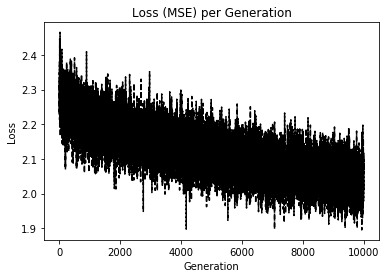

In [37]:
#plot loss over the model training
plt.plot(loss_vec,'k--',label='Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [38]:
#To test the model, we see how it performs on the test board that we removed from the training set. We are hoping
#that the model can generalize and predict the optimal index for moving, which will be the index six. Most of the time,
#the model will succeed here
test_boards = [test_board]
feed_dict = {X: test_boards}
logits = sess.run(model_output,feed_dict=feed_dict)
predictions = sess.run(prediction,feed_dict=feed_dict)
print(predictions)

[6]


In [40]:
#In order to evaluate our model, we planned to play against our trained model. To do this, we have to create a function
#that will check for a win. This way, our program will know when to stop asking for more moves
def check(board):
    wins = [[0,1,2],[3,4,5],[6,7,8],[0,3,6],[1,4,7],[2,5,8],[0,4,8],[2,4,6]]
    for i in range(len(wins)):
        if board[wins[i][0]] == board[wins[i][1]] == board[wins[i][2]] == 1.:
            return(1)
        elif board[wins[i][0]] == board[wins[i][1]] == board[wins[i][2]] == -1.:
            return(1)
    return(0)

In [44]:
#Now we can loop through and play a game with our model. We start with a blank board(all zeros), and then we ask the user
#to input an index (0-8) of where to play and then feed that into the model for a prediction. For the model's move, we
#take the largest available predictions that is also the open space. A sample game is shown at the end. From this game, 
#we can see that our model is not perfect
game_tracker = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
win_logical = False
num_moves = 0
while not win_logical:
    player_index = input('Input index of your move (0-8): ')
    num_moves += 1
    #Add player move to game
    game_tracker[int(player_index)] = 1.
    
    #Get model's move by first getting all the logits for eac index
    [potential_moves] = sess.run(model_output, feed_dict={X:[game_tracker]})
    #Now find allowed moves (where game tracker values =0.0)
    allowed_moves = [ix for ix,x in enumerate(game_tracker) if x==0.]
    #Find the best move by taking argmax of logits if they are in allowed moves
    model_move = np.argmax([x if ix in allowed_moves else -999.0 for ix,x in enumerate(potential_moves)])
    
    #Add model move to game
    game_tracker[int(model_move)] = -1.
    print('Model has moved')
    print_board(game_tracker)
    #Now check for win or too many moves
    if(check(game_tracker) == 1 or num_moves >=5):
        print('Game Over!')
        win_logical = True

Input index of your move (0-8): 3
Model has moved
   |   |  
----------
 X |   |  
----------
 O |   |  
Input index of your move (0-8): 5
Model has moved
   |   | O
----------
 X |   | X
----------
 O |   |  
Input index of your move (0-8): 1
Model has moved
   | X | O
----------
 X |   | X
----------
 O |   | O
Input index of your move (0-8): 4
Model has moved
 O | X | O
----------
 X | X | X
----------
 O |   | O
Game Over!
